<a href="https://colab.research.google.com/github/neuralsrg/SupervisedLearning/blob/main/Tensorflow/%5Btf%5Dsome_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Networks with Tensorflow

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Linear Regression

### Dataset

In [46]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [47]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# we can convert categorical variables using Pandas,
# but we'll do it later with sklearn

# insurance = pd.get_dummies(insurance)

In [48]:
# we'll predict 'charges'

X = insurance.drop('charges', axis=1)
y = insurance['charges']

In [49]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


### Splitting into train / test sets

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=32,
    shuffle = True
)

## Normalization

In [51]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

ct = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']),
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])
)

ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sex', 'smoker', 'region'])])

In [52]:
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

## Model

In [53]:
tf.random.set_seed(32)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(50,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(10,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(1,
                                kernel_initializer='glorot_uniform'))

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.mae,
    metrics=['mae']
)

In [55]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    verbose=0,
    validation_split=0.2,
    shuffle=True
)

In [56]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 2532.0222 - mae: 2532.0222


[2532.022216796875, 2532.022216796875]

Text(0.5, 0, 'epochs')

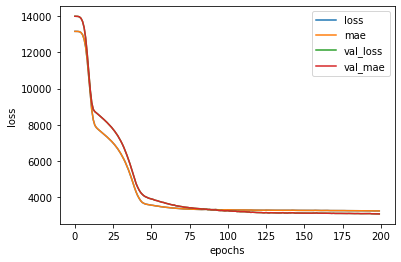

In [57]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

# Binary classification

## Dataset

In [4]:
from sklearn.datasets import make_circles

X, y = make_circles(1000, noise=0.032, random_state=32)
circles = pd.DataFrame({'x' : X[:, 0], 'y' : X[:, 1], 'label' : y})
circles.head()

,x,y,label
0,-0.072728,0.752891,1
1,-0.516691,0.531415,1
2,-0.417511,-0.690436,1
3,-0.645971,0.671942,0
4,-0.488431,-0.669703,1


In [5]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

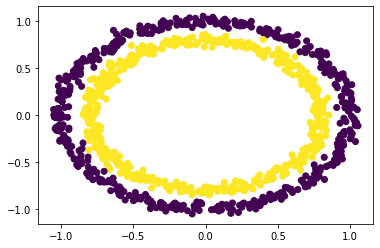

In [6]:
plt.scatter(circles['x'], circles['y'], c=circles['label'])

## Decision_boundary

In this problem **decision_boundary** might come in handy

In [1]:
import numpy as np


def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class 
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [29]:
tf.random.set_seed(32)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(10,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(1,
                                activation='sigmoid',
                                kernel_initializer='glorot_uniform'))

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['acc']
)

In [14]:
history = model.fit(
    X,
    y,
    batch_size=32,
    epochs=100,
    verbose=0,
    validation_split=0.2,
    shuffle=True
)

Text(0.5, 0, 'epochs')

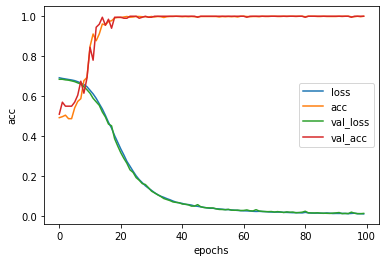

In [15]:
pd.DataFrame(history.history).plot()
plt.ylabel("acc")
plt.xlabel("epochs")

doing binary classifcation...


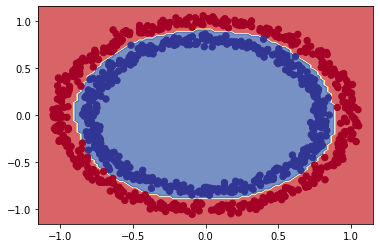

In [16]:
plot_decision_boundary(model, X, y)

## Learning rate scheduler 

In [23]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(
    X,
    y,
    batch_size=32,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=[lr_scheduler]
)

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 0.6930 - acc: 0.4925 - val_loss: 0.6889 - val_acc: 0.5250 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.4888 - val_loss: 0.6887 - val_acc: 0.5300 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.4963 - val_loss: 0.6882 - val_acc: 0.5150 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6915 - acc: 0.4988 - val_loss: 0.6877 - val_acc: 0.5000 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6911 - acc: 0.4975 - val_loss: 0.6869 - val_acc: 0.5000 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6905 - acc: 0.5000 - val_loss: 0.6870 - val_acc: 0.4950 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6898 - acc: 0.5063 - val_loss: 0.686

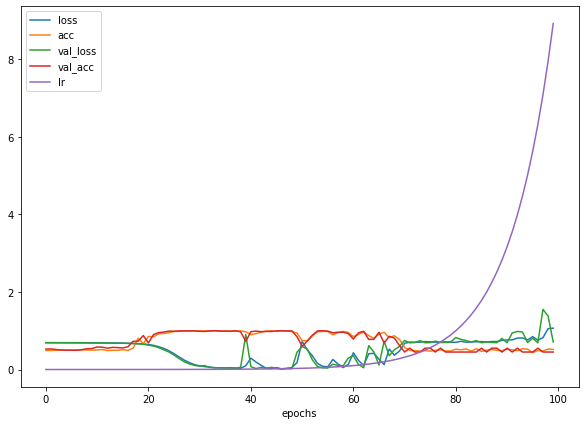

In [24]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs")

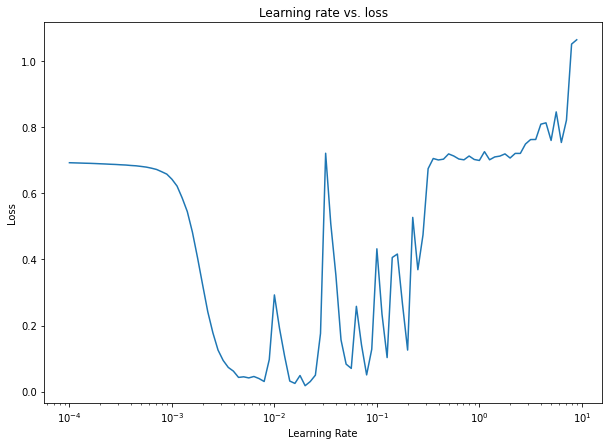

In [25]:
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [28]:
lrs[np.argmin(history.history["loss"])]

0.01995262314968879

Once we found the best learning rate, we can retrain our Net with it

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0199),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['acc']
)

In [31]:
history = model.fit(
    X,
    y,
    batch_size=32,
    epochs=25, # setting only 25 epochs
    verbose=0,
    validation_split=0.2,
    shuffle=True
)

Text(0.5, 0, 'epochs')

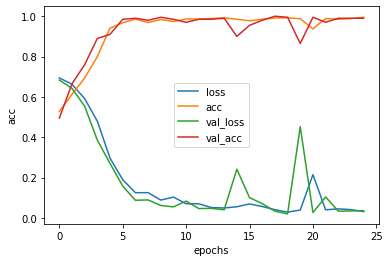

In [32]:
pd.DataFrame(history.history).plot()
plt.ylabel("acc")
plt.xlabel("epochs")

doing binary classifcation...


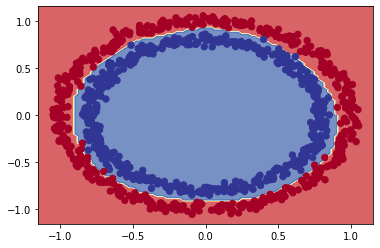

In [33]:
plot_decision_boundary(model, X, y)

## More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) or [`tfa.metrics.F1Score`](https://www.tensorflow.org/addons/api_docs/python/tfa)|
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [35]:
loss, accuracy = model.evaluate(X, y)
print(f"Model loss on train set: {loss}")
print(f"Model accuracy on train set: {(accuracy*100):.2f}%")

32/32 [==============================] - 0s 1ms/step - loss: 0.0288 - acc: 0.9920
Model loss on train set: 0.028775710612535477
Model accuracy on train set: 99.20%


### Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix

y_pred = tf.round(model.predict(X))
confusion_matrix(y, y_pred)

array([[494,   6],
       [  2, 498]])

[[True Positives, False Positives],

 [False Negatives, True Negatives]]

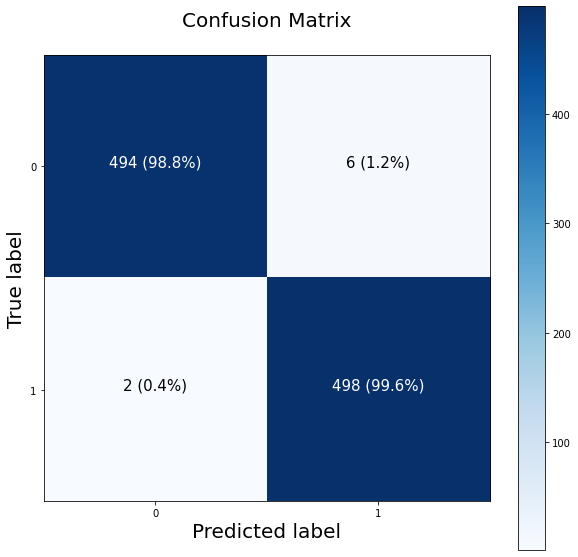

In [37]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

# Multiclass classification

In [3]:
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [40]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

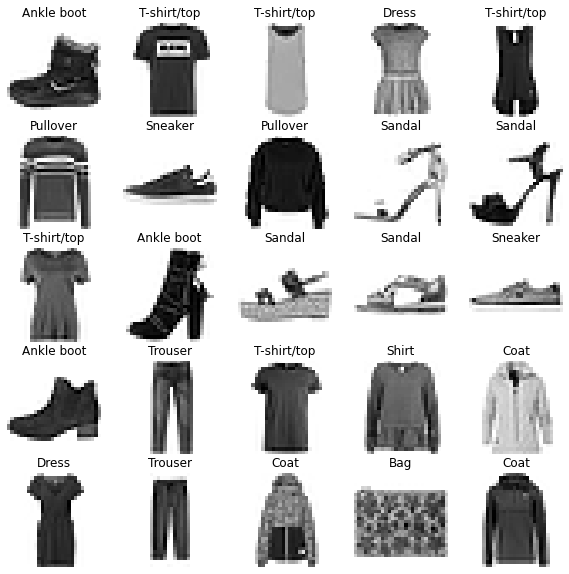

In [42]:
plt.figure(figsize=(10, 10))

for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(train_data[i].astype("uint8"), cmap=plt.cm.binary)
  plt.title(class_names[train_labels[i]])
  plt.axis("off")

## Normalizing data

In [4]:
train_data = train_data / 255.
test_data = test_data / 255.

## Dataset

## Model

In [7]:
tf.random.set_seed(32)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(4,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(10,
                                activation='softmax',
                                kernel_initializer='glorot_uniform'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc']
)

### LR scheduler

In [9]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(
    x=train_data,
    y=train_labels,
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks=[lr_scheduler],
    validation_data=(test_data, test_labels)
)

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 1.9330 - acc: 0.3019 - val_loss: 1.6423 - val_acc: 0.4514 - lr: 1.0000e-04
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3799 - acc: 0.5549 - val_loss: 1.1899 - val_acc: 0.5923 - lr: 1.1220e-04
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0613 - acc: 0.6358 - val_loss: 0.9922 - val_acc: 0.6520 - lr: 1.2589e-04
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9206 - acc: 0.6712 - val_loss: 0.8967 - val_acc: 0.6706 - lr: 1.4125e-04
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.8437 - acc: 0.6920 - val_loss: 0.8377 - val_acc: 0.6950 - lr: 1.5849e-04
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7940 - acc: 0.7182 - val_loss: 0.7981 - val_acc: 0.7212 - lr: 1.7783e-04
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7569 - ac

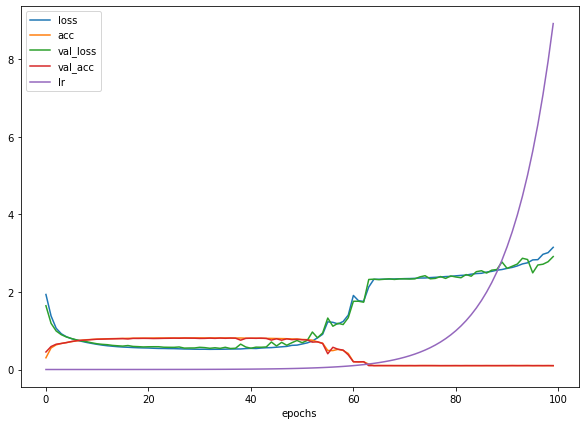

In [10]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs")

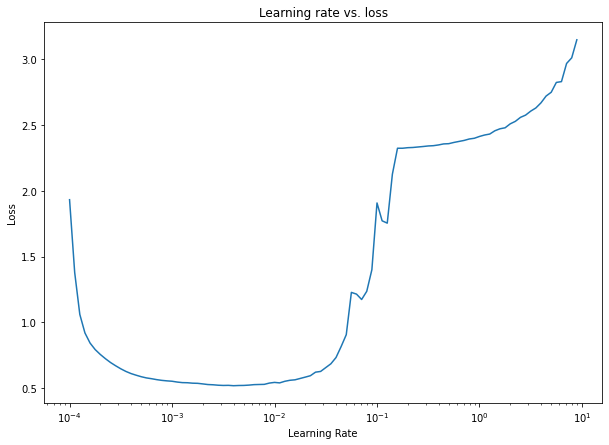

In [13]:
import numpy as np

lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [14]:
lrs[np.argmin(history.history["loss"])]

0.003981071705534973

## Training

In [15]:
tf.random.set_seed(32)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(4,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(10,
                                activation='softmax',
                                kernel_initializer='glorot_uniform'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc']
)

In [16]:
history = model.fit(
    x=train_data,
    y=train_labels,
    batch_size=32,
    epochs=40,
    verbose=1,
    validation_data=(test_data, test_labels)
)

Epoch 1/40
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1473 - acc: 0.5553 - val_loss: 0.8502 - val_acc: 0.6977
Epoch 2/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7153 - acc: 0.7515 - val_loss: 0.6996 - val_acc: 0.7571
Epoch 3/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6286 - acc: 0.7765 - val_loss: 0.6828 - val_acc: 0.7580
Epoch 4/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6091 - acc: 0.7827 - val_loss: 0.6259 - val_acc: 0.7822
Epoch 5/40
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5964 - acc: 0.7876 - val_loss: 0.6422 - val_acc: 0.7720
Epoch 6/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5903 - acc: 0.7908 - val_loss: 0.6235 - val_acc: 0.7829
Epoch 7/40
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5842 - acc: 0.7928 - val_loss: 0.6197 - val_acc: 0.7775
Epoch 8/40
1875/1875 [==============================] - 7s 4m

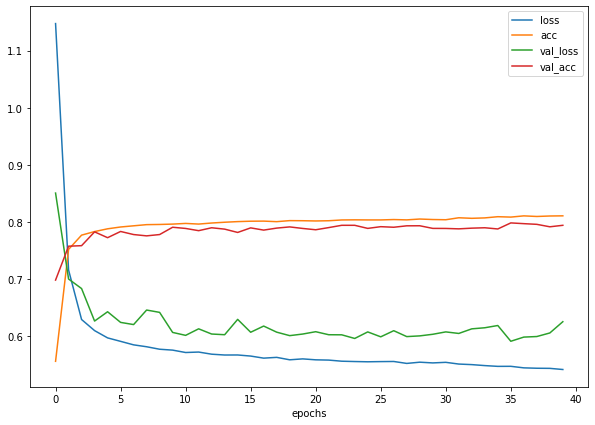

In [18]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs")

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_data).argmax(axis=1)

cm = confusion_matrix(y_true=test_labels, y_pred=y_pred)

In [ ]:
make_confusion_matrix(y_true=test_labels, 
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)